# Figure 1 Abu Dhabi Emirate area coverage by the 2023 SQMP across the various Land Use Areas

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib as mpl

from matplotlib.patches import FancyArrowPatch, Patch, Rectangle
from matplotlib.lines import Line2D

mpl.rcParams["figure.dpi"] = 300        # 屏幕显示 DPI
mpl.rcParams["savefig.dpi"] = 300       # 保存文件 DPI

In [2]:
# ============================================================
# 0) Config: paths + mapping rules
# ============================================================

# --- Excel points ---
EXCEL_PATH = r"../Soil quality data/Soil quality data 2025.xlsx"
SHEET_NAME = "PHChemical"

# --- Abu Dhabi boundaries (3 regions polygons) ---
ABU_DHABI_SHP = r"../data_hmq/Map/abu_dhabi.shp"

# --- Protected Areas ---
PROTECTED_GPKG = "../data_hmq/Map/abu_dhabi_protected_areas.gpkg"
PROTECTED_LAYER = "Protected_Areas"

# --- SurveyID -> land use class mapping ---
SURVEY_ID = {
    "Industrial": 9,
    "Residential": 8,
    "Agricultural": 7,
    "Non-developed": 11,
}

POINT_STYLE = {
    "Agricultural": {"color": "#7BD54A", "ms": 25},
    "Residential":  {"color": "#4B9FB3", "ms": 25},
    "Industrial":   {"color": "#D96A3A", "ms": 25},
    "Non-developed":{"color": "#5B5B4D", "ms": 22},
}

PROTECTED_STYLE = {
    "facecolor": "#7FD3C3",
    "alpha": 0.6,
    "edgecolor": "#7FD3C3",
}

BASEMAP = cx.providers.Esri.WorldGrayCanvas
BASEMAP_ZOOM = 7


In [3]:
# ============================================================
# 1) Helper: extract unique sampling sites (deduplicate by SiteUID)
# ============================================================

def points_from_excel(df: pd.DataFrame, survey_id: int) -> gpd.GeoDataFrame:
    sub = df[df["SurveyID"] == survey_id].copy()
    sub = sub.dropna(subset=["Longitude", "Latitude", "SiteUID"])
    sub = sub.sort_values("SiteUID").drop_duplicates(subset=["SiteUID"])

    gdf = gpd.GeoDataFrame(
        sub,
        geometry=gpd.points_from_xy(sub["Longitude"], sub["Latitude"]),
        crs="EPSG:4326",
    ).to_crs(3857)
    return gdf


In [4]:
# ============================================================
# 2) Map decorations: north arrow + scale bar
# ============================================================

def add_north_arrow(ax, x=0.05, y=0.86, dy=0.07):
    arrow = FancyArrowPatch(
        (x, y), (x, y + dy),
        transform=ax.transAxes,
        arrowstyle="-|>",
        linewidth=1.2,
        color="black",
        zorder=30
    )
    ax.add_patch(arrow)
    ax.text(
        x, y + dy + 0.01, "N",
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=10, zorder=30
    )

def add_scale_bar(ax, xmin, ymin, xmax, ymax, length_km=200):
    length_m = length_km * 1000
    x0 = xmin + 0.05 * (xmax - xmin)
    y0 = ymin + 0.05 * (ymax - ymin)

    ax.plot([x0, x0 + length_m], [y0, y0],
            color="black", linewidth=4, zorder=30)

    ax.text(x0, y0 - 0.02 * (ymax - ymin), "0",
            ha="center", va="top", fontsize=9)

    ax.text(x0 + length_m, y0 - 0.02 * (ymax - ymin),
            f"{length_km} km",
            ha="center", va="top", fontsize=9)


In [5]:
# ============================================================
# 3) Read sampling points from Excel
# ============================================================

data = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)

gdf_agr = points_from_excel(data, SURVEY_ID["Agricultural"])
gdf_res = points_from_excel(data, SURVEY_ID["Residential"])
gdf_ind = points_from_excel(data, SURVEY_ID["Industrial"])
gdf_non = points_from_excel(data, SURVEY_ID["Non-developed"])

print("Sampling sites (deduplicated by SiteUID):")
print("Agricultural:", len(gdf_agr))
print("Residential: ", len(gdf_res))
print("Industrial:  ", len(gdf_ind))
print("Non-developed:", len(gdf_non))


FileNotFoundError: [Errno 2] No such file or directory: '../Soil quality data/Soil quality data 2025.xlsx'

In [26]:
# ============================================================
# 4) Read Abu Dhabi boundaries + protected areas (NO clipping)
# ============================================================

regions = gpd.read_file(ABU_DHABI_SHP).to_crs(3857)

protected = gpd.read_file(PROTECTED_GPKG, layer=PROTECTED_LAYER).to_crs(3857)
protected = protected[(~protected.geometry.isna()) & (~protected.geometry.is_empty)].copy()

print("Regions columns:", list(regions.columns))
print("Protected areas:", len(protected))
print("Regions bounds:", regions.total_bounds)


Regions columns: ['ID', 'NAME', 'TOTPOP_CY', 'AREA', 'geometry']
Protected areas: 19
Regions bounds: [5732930.9417 2587516.6535 6235907.6832 2906880.8149]


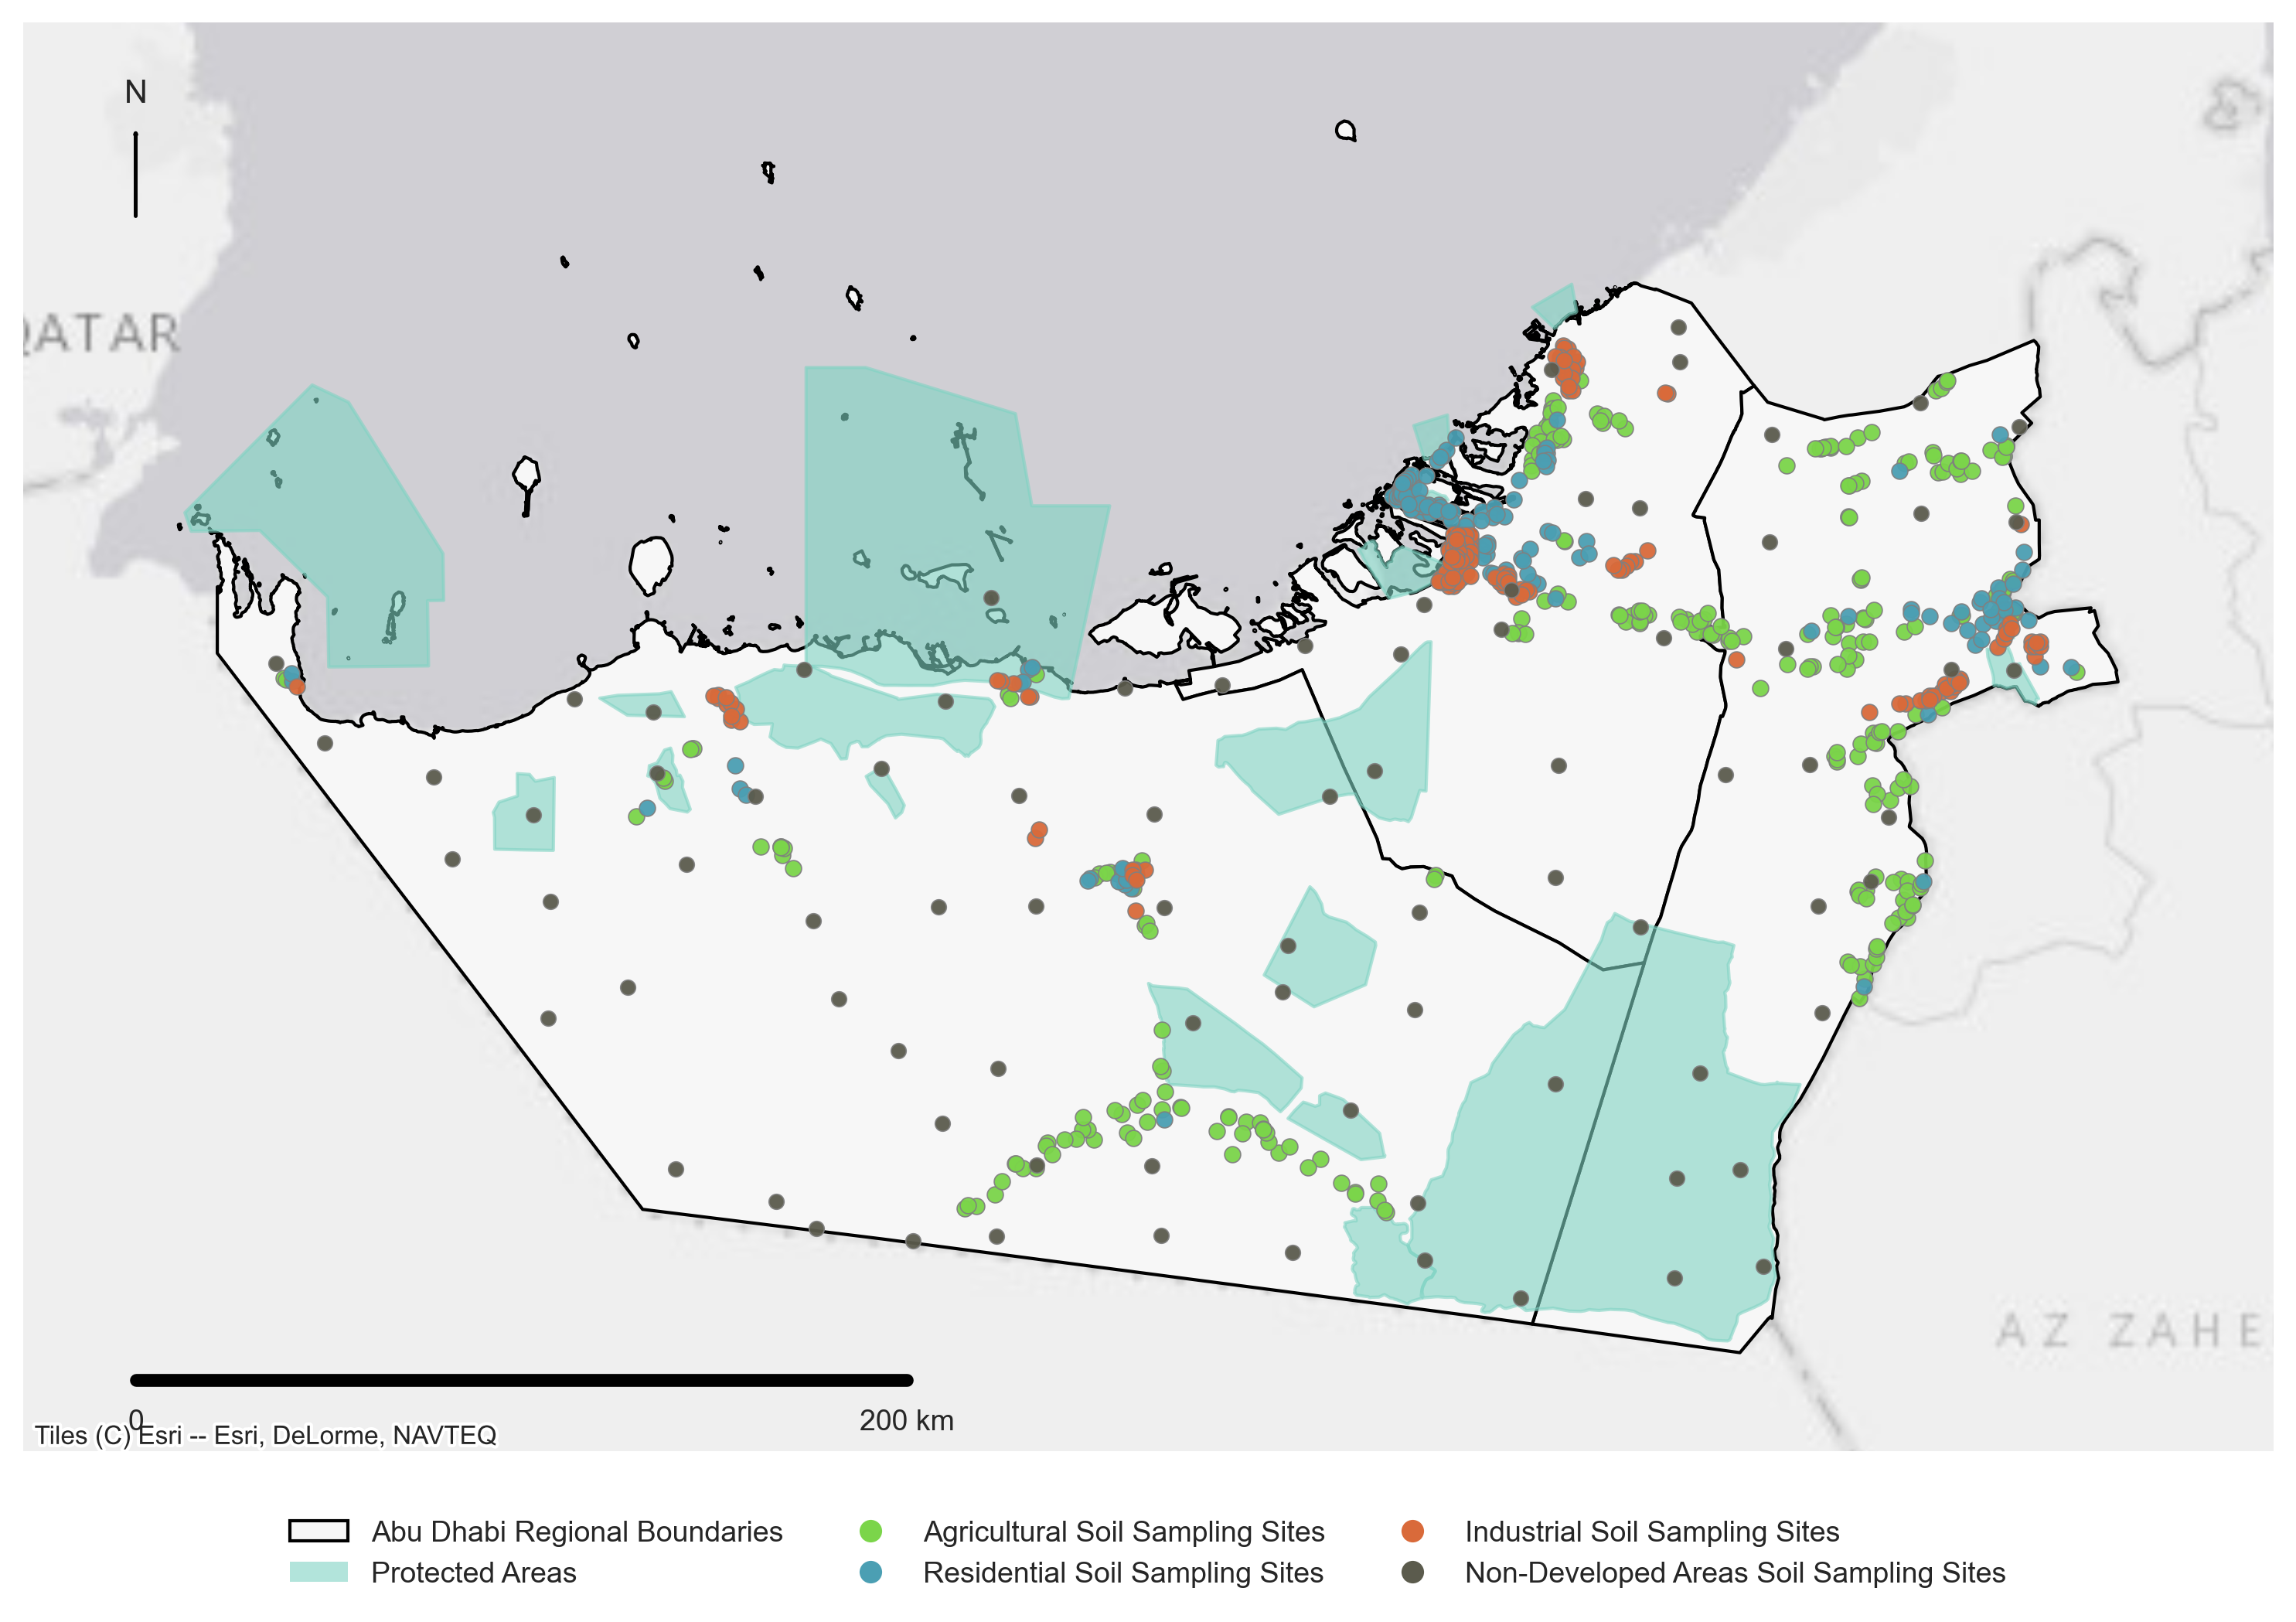

In [27]:
# ============================================================
# 5) Plot
# ============================================================

fig, ax = plt.subplots(figsize=(12, 8))
plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0.18)

# --- map extent based on Abu Dhabi boundaries ---
xmin, ymin, xmax, ymax = regions.total_bounds
xpad = 0.08 * (xmax - xmin)
ypad = 0.08 * (ymax - ymin)
ax.set_xlim(xmin - xpad, xmax + xpad)
ax.set_ylim(ymin - ypad, ymax + ypad)

# --- basemap ---
cx.add_basemap(ax, source=BASEMAP, zoom=BASEMAP_ZOOM)

# --- regions polygons ---
regions.plot(
    ax=ax,
    facecolor="#f7f7f7",
    edgecolor="black",
    linewidth=1,
    zorder=3
)

# --- protected areas overlay ---
protected.plot(
    ax=ax,
    facecolor=PROTECTED_STYLE["facecolor"],
    edgecolor=PROTECTED_STYLE["edgecolor"],
    alpha=PROTECTED_STYLE["alpha"],
    zorder=4
)

# --- sampling points ---
plot_kwargs = dict(marker="o", edgecolor="grey", linewidth=0.4, alpha=0.95, zorder=10)

gdf_agr.plot(ax=ax, color=POINT_STYLE["Agricultural"]["color"], markersize=POINT_STYLE["Agricultural"]["ms"], **plot_kwargs)
gdf_res.plot(ax=ax, color=POINT_STYLE["Residential"]["color"],  markersize=POINT_STYLE["Residential"]["ms"],  **plot_kwargs)
gdf_ind.plot(ax=ax, color=POINT_STYLE["Industrial"]["color"],   markersize=POINT_STYLE["Industrial"]["ms"],   **plot_kwargs)
gdf_non.plot(ax=ax, color=POINT_STYLE["Non-developed"]["color"],markersize=POINT_STYLE["Non-developed"]["ms"],**plot_kwargs)

# --- north arrow + scale bar ---
add_north_arrow(ax)
add_scale_bar(ax, xmin - xpad, ymin - ypad, xmax + xpad, ymax + ypad, length_km=200)

# --- legend ---
legend_elements = [
    Patch(facecolor="#f7f7f7", edgecolor="black", label="Abu Dhabi Regional Boundaries"),
    Patch(facecolor=PROTECTED_STYLE["facecolor"], edgecolor="none",
          alpha=PROTECTED_STYLE["alpha"], label="Protected Areas"),

    Line2D([0], [0], marker='o', color='w', label='Agricultural Soil Sampling Sites',
           markerfacecolor=POINT_STYLE["Agricultural"]["color"], markersize=8),

    Line2D([0], [0], marker='o', color='w', label='Residential Soil Sampling Sites',
           markerfacecolor=POINT_STYLE["Residential"]["color"], markersize=8),

    Line2D([0], [0], marker='o', color='w', label='Industrial Soil Sampling Sites',
           markerfacecolor=POINT_STYLE["Industrial"]["color"], markersize=8),

    Line2D([0], [0], marker='o', color='w', label='Non-Developed Areas Soil Sampling Sites',
           markerfacecolor=POINT_STYLE["Non-developed"]["color"], markersize=8),
]

ax.legend(
    handles=legend_elements,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.03),
    frameon=False,
    fontsize=9,
    ncol=3
)

ax.set_axis_off()
plt.show()


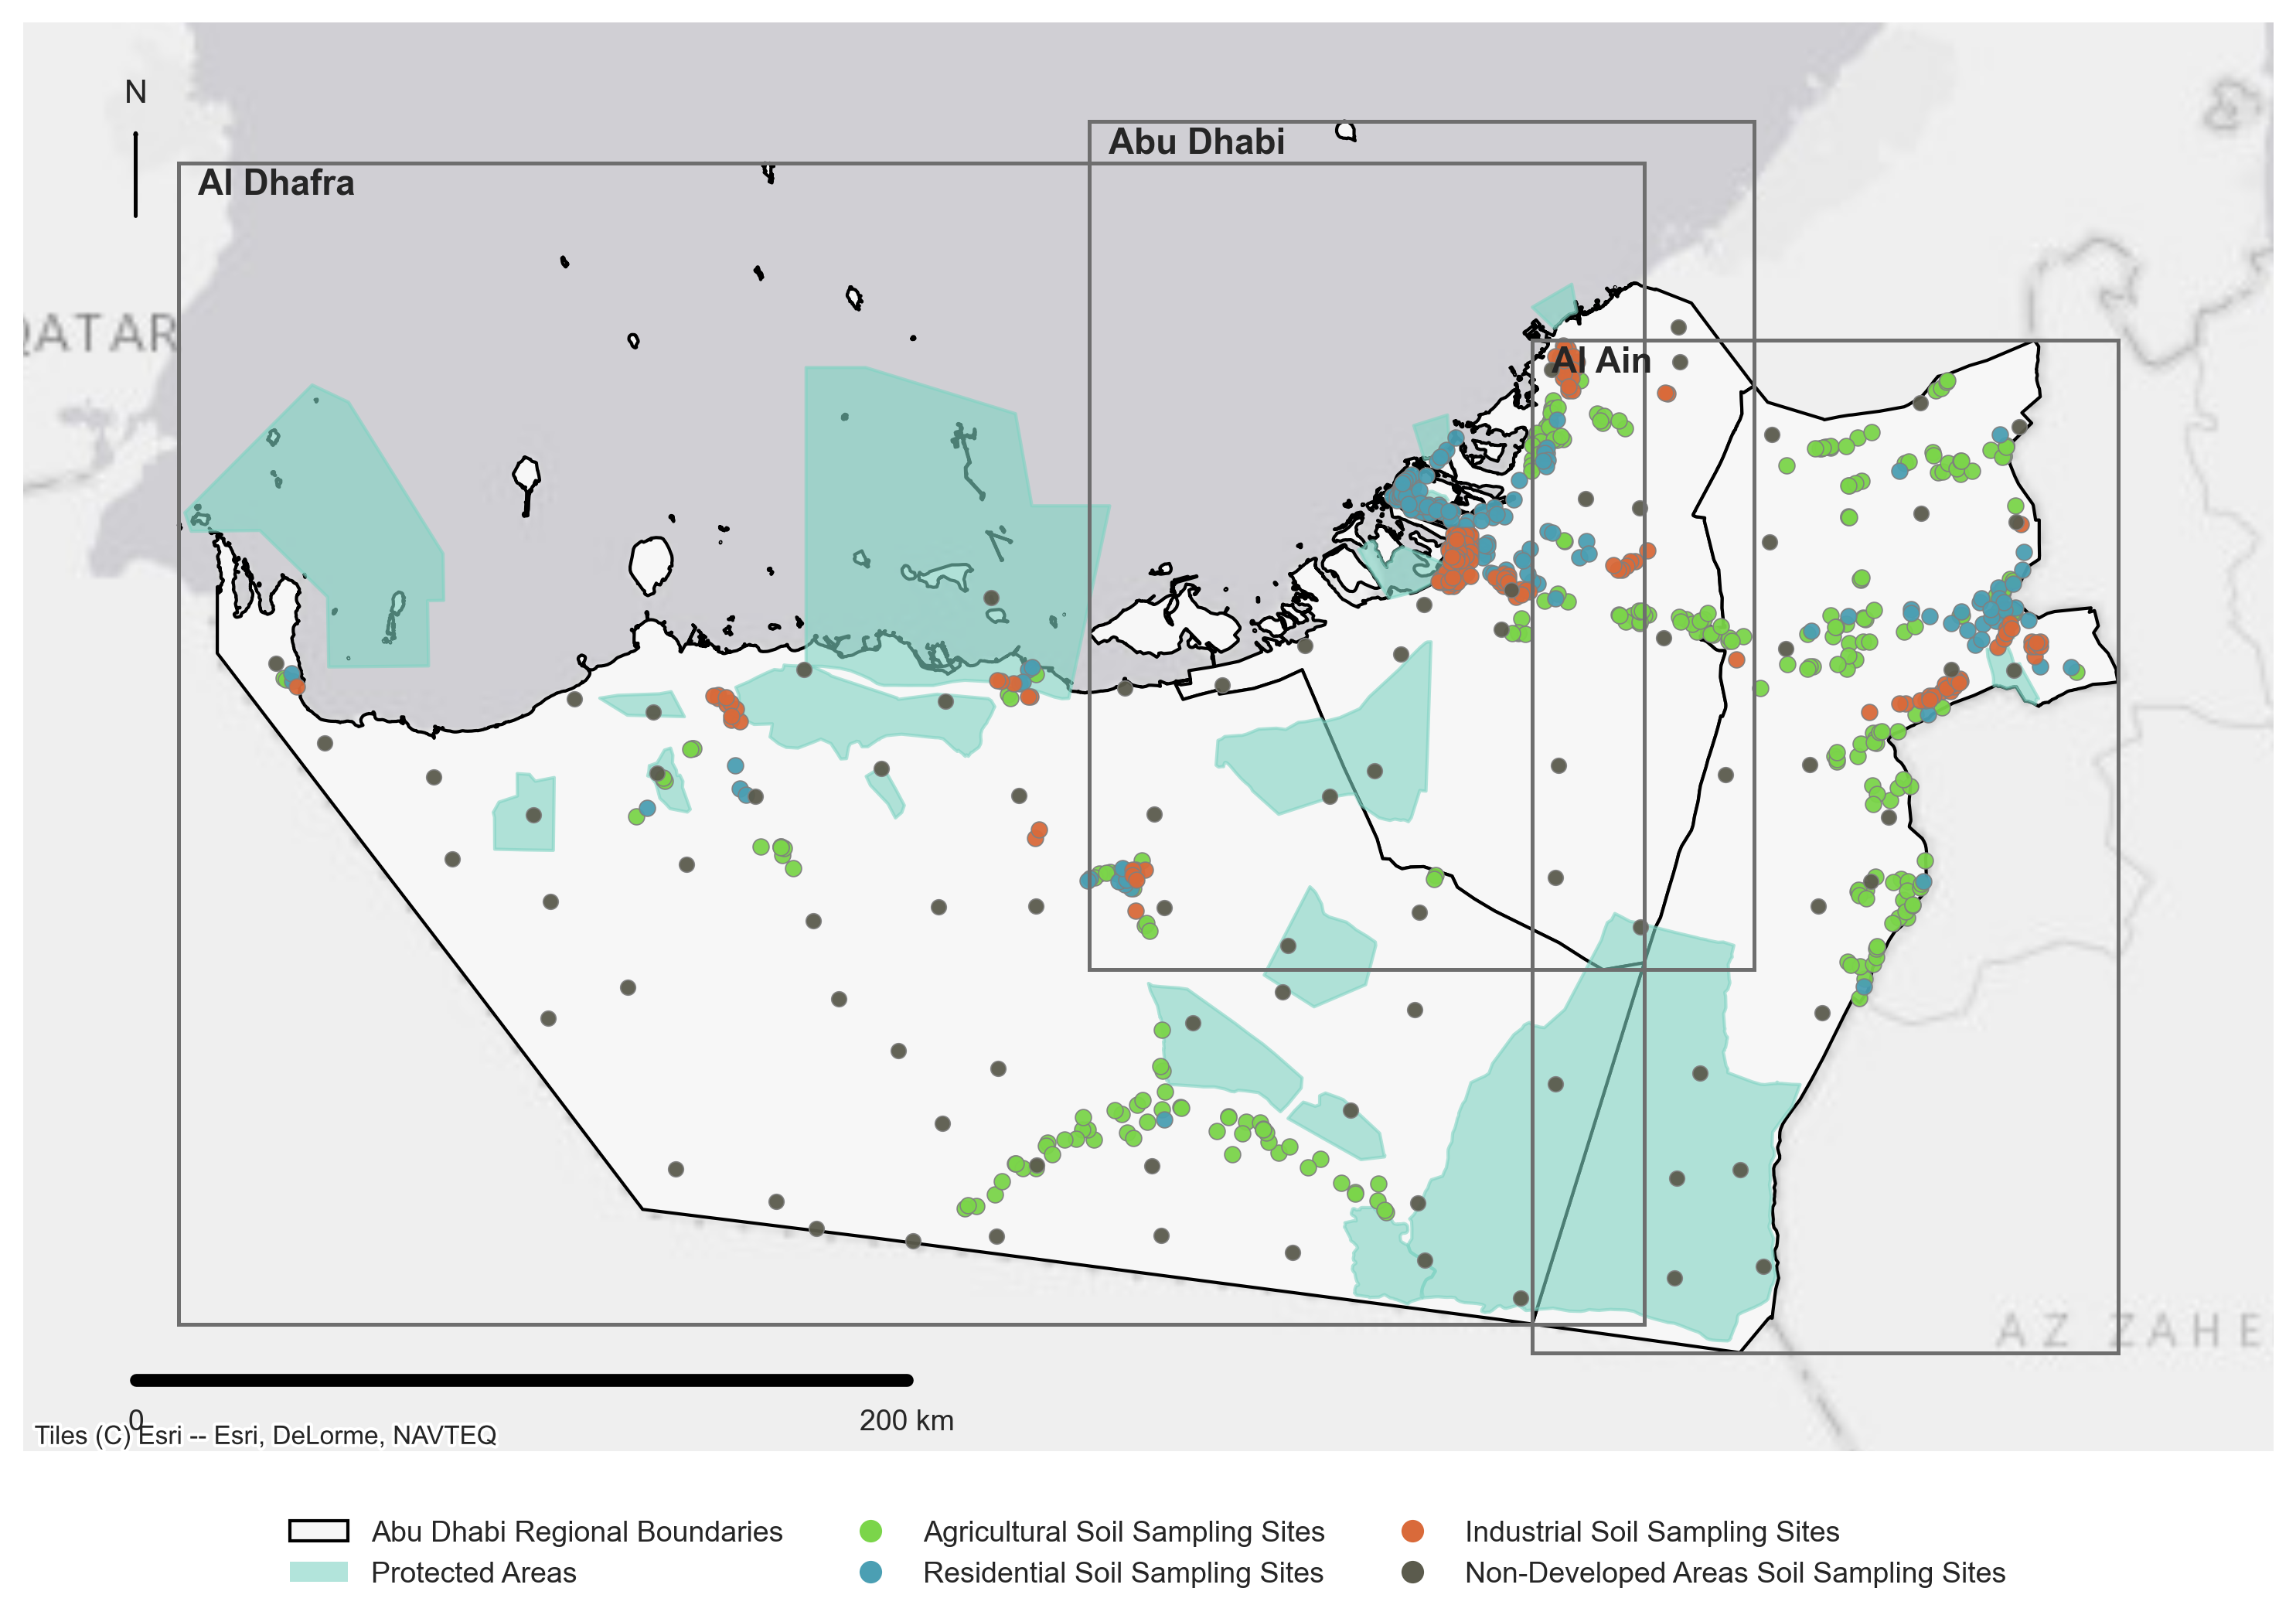

In [31]:
# ============================================================
# 6) 3 AOI rectangles (derived from region polygons)
# ============================================================

NAME_DHAFRA   = "Al - Dhafra Region"
NAME_ABUDHABI = "Abu Dhabi Region"
NAME_ALAIN    = "Al - Ain Region"

candidate_fields = ["NAMEENGLISH", "NameEnglish", "NAME", "Name", "Region", "REGION", "emirate", "EMIRATE"]
name_field = None
for f in candidate_fields:
    if f in regions.columns:
        name_field = f
        break

fig, ax = plt.subplots(figsize=(12, 8))
plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0.18)

# extent
xmin, ymin, xmax, ymax = regions.total_bounds
xpad = 0.08 * (xmax - xmin)
ypad = 0.08 * (ymax - ymin)
ax.set_xlim(xmin - xpad, xmax + xpad)
ax.set_ylim(ymin - ypad, ymax + ypad)

# basemap + layers (same as before)
cx.add_basemap(ax, source=BASEMAP, zoom=BASEMAP_ZOOM)

regions.plot(ax=ax, facecolor="#f7f7f7", edgecolor="black", linewidth=1, zorder=3)
protected.plot(ax=ax, facecolor=PROTECTED_STYLE["facecolor"],
               edgecolor=PROTECTED_STYLE["edgecolor"], alpha=PROTECTED_STYLE["alpha"], zorder=4)

plot_kwargs = dict(marker="o", edgecolor="grey", linewidth=0.4, alpha=0.95, zorder=10)
gdf_agr.plot(ax=ax, color=POINT_STYLE["Agricultural"]["color"], markersize=POINT_STYLE["Agricultural"]["ms"], **plot_kwargs)
gdf_res.plot(ax=ax, color=POINT_STYLE["Residential"]["color"],  markersize=POINT_STYLE["Residential"]["ms"],  **plot_kwargs)
gdf_ind.plot(ax=ax, color=POINT_STYLE["Industrial"]["color"],   markersize=POINT_STYLE["Industrial"]["ms"],   **plot_kwargs)
gdf_non.plot(ax=ax, color=POINT_STYLE["Non-developed"]["color"],markersize=POINT_STYLE["Non-developed"]["ms"],**plot_kwargs)

add_north_arrow(ax)
add_scale_bar(ax, xmin - xpad, ymin - ypad, xmax + xpad, ymax + ypad, length_km=200)

# legend
ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, -0.03),
          frameon=False, fontsize=9, ncol=3)

# AOI boxes
if name_field is None:
    print("Cannot find a name field in abu_dhabi.shp. Available columns are:")
    print(list(regions.columns))
else:
    gdf_dhafra   = regions[regions[name_field].astype(str).str.contains(NAME_DHAFRA,   case=False, na=False)]
    gdf_abudhabi = regions[regions[name_field].astype(str).str.contains(NAME_ABUDHABI, case=False, na=False)]
    gdf_alain    = regions[regions[name_field].astype(str).str.contains(NAME_ALAIN,    case=False, na=False)]

    PAD = 0
    BOX_STYLE = dict(fill=False, edgecolor="#6e6e6e", linewidth=1.2, zorder=20)
    text_padding_x = 5000
    text_padding_y = 10000

    def bounds_with_pad(gdf):
        x1, y1, x2, y2 = gdf.total_bounds
        dx, dy = (x2 - x1), (y2 - y1)
        return (x1 - PAD*dx, y1 - PAD*dy, x2 + PAD*dx, y2 + PAD*dy)

    for gdf_box, label in [(gdf_dhafra, "Al Dhafra"),
                           (gdf_abudhabi, "Abu Dhabi"),
                           (gdf_alain, "Al Ain")]:
        if len(gdf_box) == 0:
            print(f"Warning: '{label}' not matched in {name_field}.")
            continue
        x1, y1, x2, y2 = bounds_with_pad(gdf_box)
        ax.add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1, **BOX_STYLE))
        ax.text(x1 + text_padding_x, y2 - text_padding_y, label,
                fontsize=11, weight="bold", va="bottom", zorder=21)

ax.set_axis_off()
plt.show()
fig.savefig("../Result_hmq/Ch01_Figure1.svg", bbox_inches="tight", pad_inches=0.1)
fig.savefig("../Result_hmq/Ch01_Figure1.png", bbox_inches="tight", pad_inches=0.1)


In [29]:
# Optional: save figure
# fig.savefig("../Result_hmq/Figure1-1.png")